In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns
import statistics
from meegkit import dss

from pycrostates.preprocessing import extract_gfp_peaks
from proof_of_consept import unit_normalize
from neurokit2.microstates.microstates_clean import microstates_clean
from mne_icalabel import label_components
from scipy.stats import kurtosis, skew

In [2]:
def zapline_clean(raw, fline):
    data = raw.get_data().T # Convert mne data to numpy darray
    sfreq = raw.info['sfreq'] # Extract the sampling freq
   
    #Apply MEEGkit toolbox function
    out, _ = dss.dss_line(data, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    print(out.shape)

    cleaned_raw = mne.io.RawArray(out.T, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [3]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro")
file = data_folder / "sub-002_ses-t1_task-resteyesc_eeg.edf"
#processed_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned")
#processed_file = processed_folder / "sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set"

raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#Be carefull that artifact electrodes are not included in the average calc.
print(raw.info['ch_names'])
raw.set_montage('biosemi64')
#raw.drop_channels('O2')#raw.info["bads"].append("O2")
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#raw.set_montage('biosemi64')

#bridged, dist = mne.preprocessing.compute_bridged_electrodes(raw)


raw_highpass = raw.copy().filter(l_freq=1, h_freq=None, verbose=False)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=100, verbose=False)
line_noise = zapline_clean(raw_lowpass, 50)
raw_down_sampled = line_noise.copy().resample(sfreq=200, verbose=False)
raw_down_sampled.set_eeg_reference(ref_channels='average')
#I should maybe downsample, and maybe do it first for computational efficiency. The only thing is that then almost all the data will be in simpochs, so maybe I need stricter limits for gfp peakes.
#Bad segments can maybe be identified with Christoffers algorithm, anything else? I want to do this at the end of the pipeline I think.

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
[PCA] Explained variance of selected components : 28.48%
Power of components removed by DSS: 0.19
(245760, 64)
Creating RawArray with float64 data, n_channels=64, n_times=245760
    Range : 0 ... 245759 =      0.000 ...   239.999 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawArray | 64 x 48000 (240.0 s), ~23.5 MB, data loaded>

In [4]:
print(raw_down_sampled.get_data().shape)

(64, 48000)


In [5]:
def gfp_normed_diss_data(indices, data, gfp):
    all_inx = np.arange(data.shape[1])
    unorderd_adj_indices = np.array([indices, (indices-1)]).flatten()
    anti_adj_indices = np.delete(all_inx, unorderd_adj_indices)
    all_inx = np.arange(data.shape[1])
    adj_indices = np.delete(all_inx, anti_adj_indices)

    indexed_data = data[:, adj_indices]
    indexed_gfp = gfp[adj_indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

def gfp_normed_diss_data2(indices, data, gfp):
    indexed_data = data[:, indices]
    indexed_gfp = gfp[indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

In [6]:
def diss(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices), data.shape[0]))
    for t in range(0, len(indices)*2, 2):
        diss[int(t/2), :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t+1])
    return diss

def diss2(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data2(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices)-1, data.shape[0]))
    for t in range(1, len(indices)):
        diss[t-1, :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t-1])
    return diss

In [57]:
def epoched_stability1(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stabilty = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        d = diss(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stabilty[e] = np.mean(for_convex)
    return stability, convex_stabilty

def epoched_stability2(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stability = np.ndarray(shape=(epochs_array.shape[0]))
    switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    significant_switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    peaks = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        if e == 0:
            data_at_peaks = data[:, indices]
            full_data = data
        else:
            data_at_peaks = np.concatenate((data_at_peaks, data[:, indices]), axis=1)
            full_data = np.concatenate((full_data, data), axis=1)
        d = diss2(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        freq = 0
        sfreq = 0
        for s in individual_map_stability:
            if s > 0:
                freq += 1
            if s > 0.4:
                sfreq += 1
        switching_freq[e] = freq
        significant_switching_freq[e] = sfreq
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stability[e] = np.mean(for_convex)
        peaks[e] = len(indices)
    return stability, switching_freq, convex_stability, significant_switching_freq, peaks, full_data, data_at_peaks

Bad epoch idenfication - based on topographic stability

Between GFP peaks

In [8]:
ones_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, overlap=0.5)

In [9]:
print(ones_epochs.get_data().shape)

Using data from preloaded Raw for 479 events and 200 original time points ...
0 bad epochs dropped
(479, 64, 200)


In [10]:
epoched_stability, epoched_switching_freq, convex_stabilty, significant_switching_freq, peaks, _, _ = epoched_stability2(ones_epochs)

Using data from preloaded Raw for 479 events and 200 original time points ...


Plots to investigate exclusion of epocs not following our assumptions.

Epoch averaged DISS

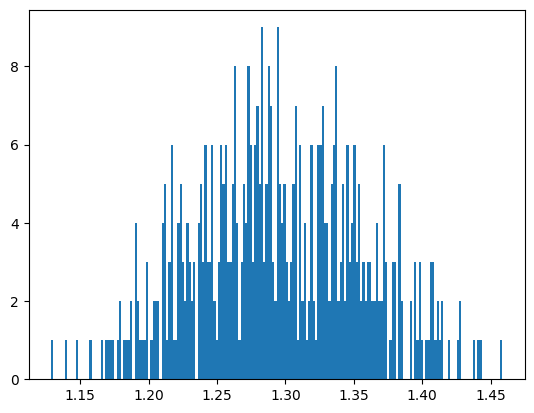

In [11]:
plt.hist(convex_stabilty, bins=200)
plt.show()

In [12]:
timepoints = np.where(convex_stabilty<0)[0]
print((timepoints)/2)

[]


Stability transformed: absoluteDISS = |DISS-1| ... and averaged for each epoch. Now only high values indicate stability.

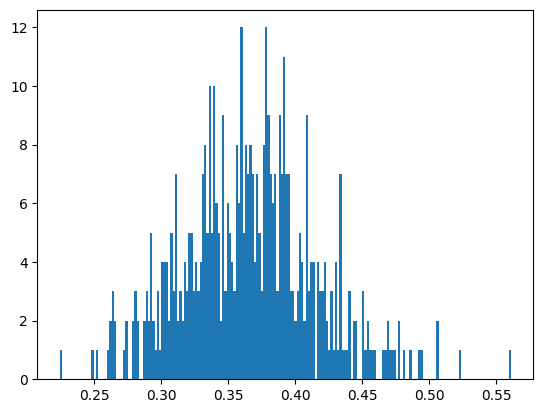

In [13]:
plt.hist(epoched_stability, bins=200)
plt.show()

In [14]:
timepoints = np.where(epoched_stability<0)[0]
print((timepoints)/2)

[]


Average epoch polarity inversion going from gfp peak to gfp peak, meaning DISS < 1.

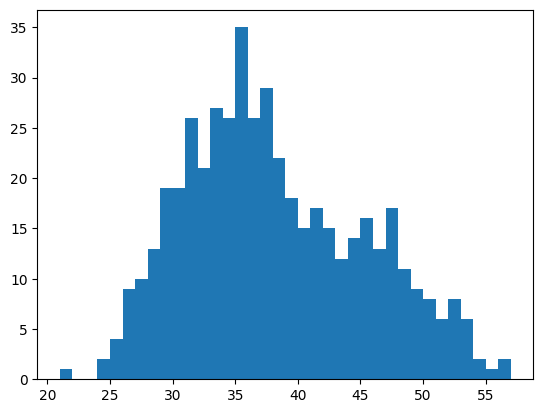

In [15]:
plt.hist(epoched_switching_freq, bins=36)
plt.show()

In [16]:
timepoints = np.where(epoched_switching_freq>300)[0]
print((timepoints)/2)

[]


The same again, but only for shifts in polarity where higher stability is indicated (DISS > 1.4)

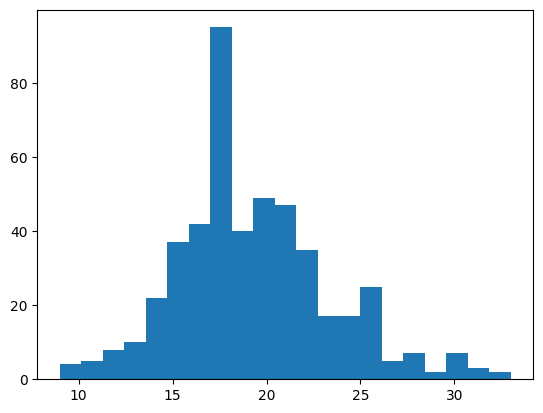

In [17]:
plt.hist(significant_switching_freq, bins=21)
plt.show()

In [18]:
timepoints = np.where(significant_switching_freq==-1)[0]
print((timepoints)/2)

[]


Number of GFP peaks for each epoch

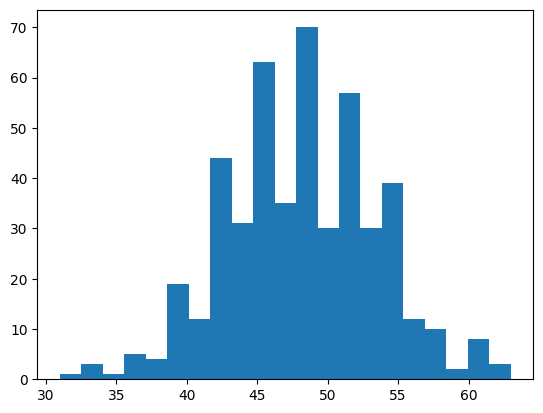

In [19]:
plt.hist(peaks, bins=21)
plt.show()

In [20]:
timepoints = np.where(peaks>500)[0]
print((timepoints)/2)

[]


Looking at scatter plot between swithcing frequencies and number of GFP peaks

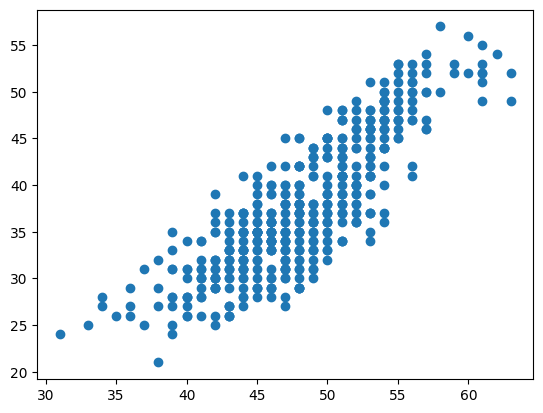

In [21]:
plt.scatter(peaks, epoched_switching_freq)
plt.show()

In [22]:
idx = np.where((epoched_switching_freq < 0))[0]
print((idx-1)/2)

[]


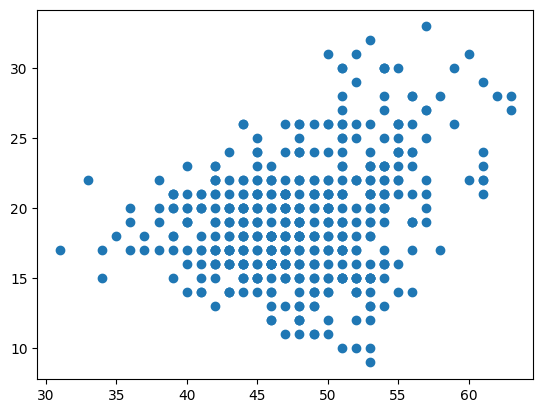

In [23]:
plt.scatter(peaks, significant_switching_freq)
plt.show()

In [24]:
idx = np.where((peaks > 57))[0]
print(idx)
print((idx-1)/2)

idx = np.where((peaks < 28) & (significant_switching_freq < 9))[0]
print((idx-1)/2)

idx = np.where((significant_switching_freq == 0))[0]
print((idx-1)/2)

[313 314 371 372 373 376 403 412 423 424 425 431 432 472 473]
[156.  156.5 185.  185.5 186.  187.5 201.  205.5 211.  211.5 212.  215.
 215.5 235.5 236. ]
[]
[]


Looking at average absoluteDISS in relation to switching frequencies.

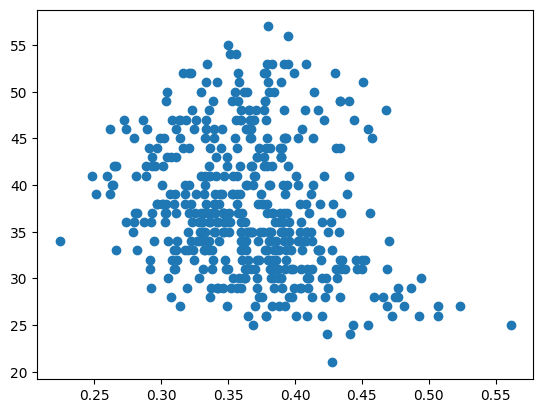

In [25]:
plt.scatter(epoched_stability, epoched_switching_freq)
plt.show()

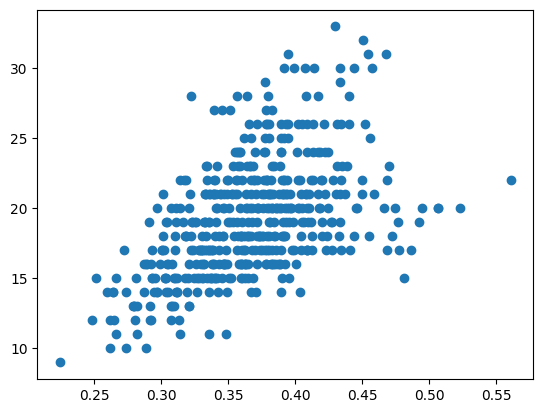

In [26]:
plt.scatter(epoched_stability, significant_switching_freq)
plt.show()

In [27]:
idx = np.where((epoched_stability > 10.5) & (significant_switching_freq < 5))[0]
print((idx-1)/2)

[]


Same but with average DISS

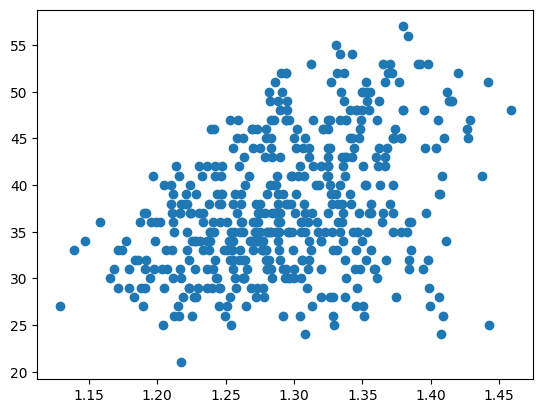

In [28]:
plt.scatter(convex_stabilty, epoched_switching_freq)
plt.show()

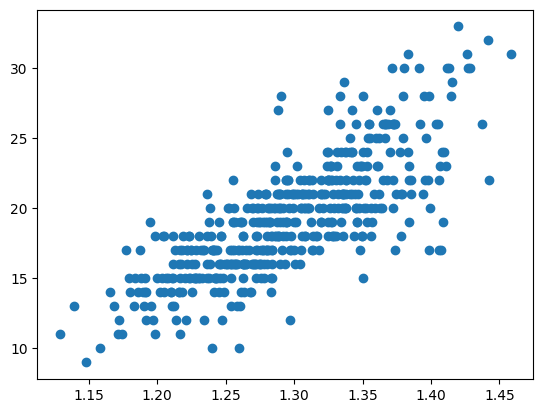

In [29]:
plt.scatter(convex_stabilty, significant_switching_freq)
plt.show()

In [30]:
print(epoched_stability[110*2], convex_stabilty[110*2], epoched_switching_freq[110*2], significant_switching_freq[110*2])

0.32833900521030485 1.227581850510201 34.0 15.0


In [31]:
print(epoched_stability[int(109.5*2)], convex_stabilty[int(109.5*2)], epoched_switching_freq[int(109.5*2)], significant_switching_freq[int(109.5*2)])

0.32072751687823314 1.2110393043749461 37.0 13.0


In [32]:
print(epoched_stability[int(110.5*2)], convex_stabilty[int(110.5*2)], epoched_switching_freq[int(110.5*2)], significant_switching_freq[int(110.5*2)])

0.2924076775491188 1.2115337678567883 36.0 16.0


Scatter of the two stability types

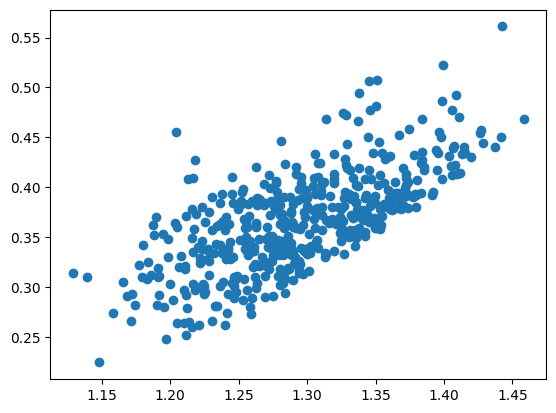

In [33]:
plt.scatter(convex_stabilty, epoched_stability)
plt.show()

In [34]:
idx = np.where((epoched_stability>10.6) & (convex_stabilty<0.75))[0]
print(idx)
print((idx)/2)

[]
[]


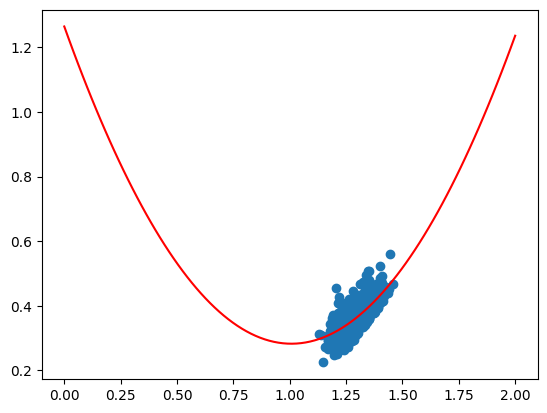

In [35]:
fit = np.poly1d(np.polyfit(convex_stabilty, epoched_stability, 2))
polyline = np.linspace(0, 2, 100)
plt.scatter(convex_stabilty, epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.show()


In [36]:
print(fit)

        2
0.9682 x - 1.951 x + 1.265


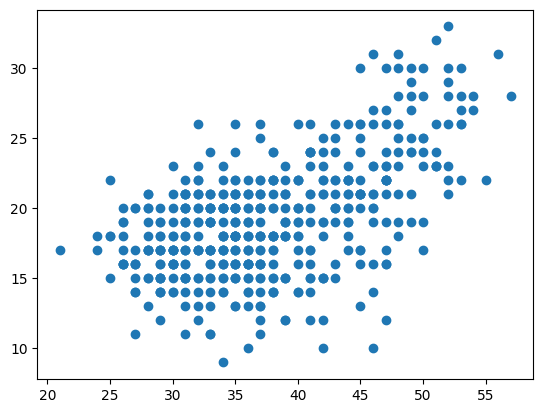

In [37]:
plt.scatter(epoched_switching_freq, significant_switching_freq)
plt.show()

In [38]:
idx = np.where((epoched_switching_freq > 250) & (significant_switching_freq < 15))[0]
print((idx-1)/2)

[]


In [39]:
channel_names = np.array(raw_down_sampled.info['ch_names'])

At GFP peaks

In [40]:
at_epoched_stability, at_convex_stabilty = epoched_stability1(ones_epochs)

Using data from preloaded Raw for 479 events and 200 original time points ...


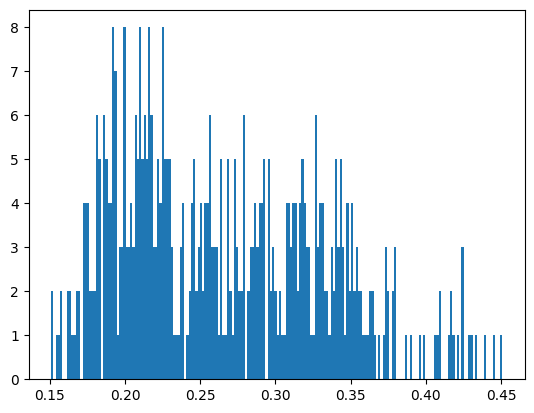

In [41]:
plt.hist(at_epoched_stability, bins=200)
plt.show()

In [42]:
idx = np.where(at_epoched_stability > 10.85)[0]
print((idx-1)/2)
idx = np.where(at_epoched_stability < 0.04)[0]
print((idx-1)/2)

[]
[]


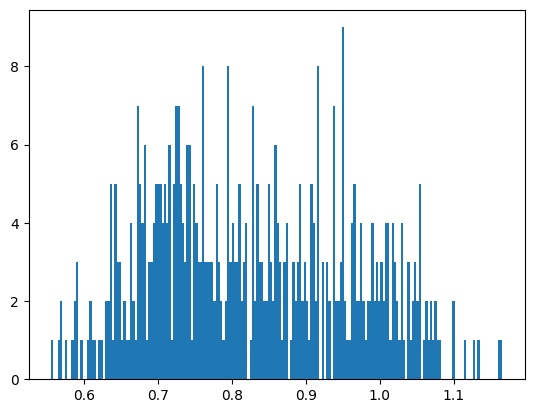

In [43]:
plt.hist(at_convex_stabilty, bins=200)
plt.show()

In [44]:
idx = np.where(at_convex_stabilty > 10.8)[0]
print((idx-1)/2)
idx = np.where(at_convex_stabilty < 0.015)[0]
print((idx-1)/2)

[]
[]


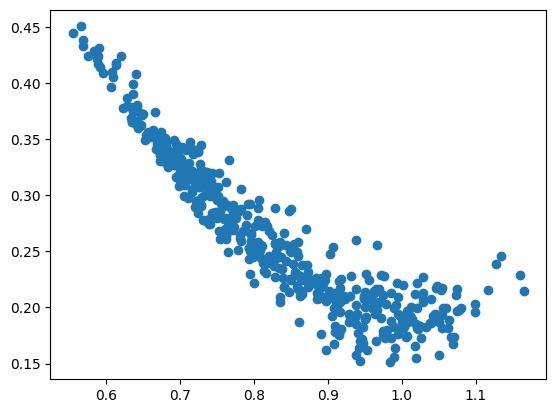

In [45]:
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.show()

In [46]:
idx = np.where((at_convex_stabilty > 10.8) & (at_epoched_stability < 0.04))[0]
print((idx-1)/2)

[]


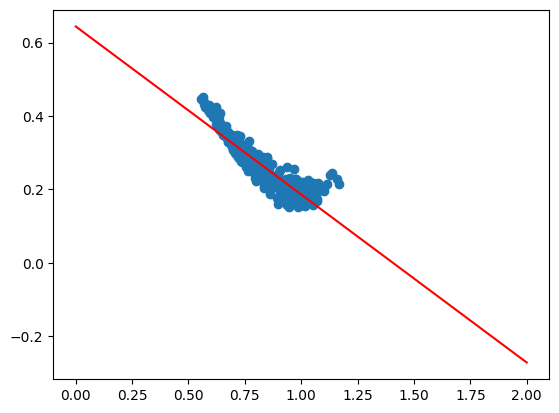

In [47]:
fit = np.poly1d(np.polyfit(at_convex_stabilty, at_epoched_stability, 1))
polyline = np.linspace(0, 2, 100)
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.show()

In [48]:
print(fit)

 
-0.4577 x + 0.6441


The median prinsipal for channel stability and pca heuristic analysis

In [49]:
idx = np.where((epoched_stability>=np.median(epoched_stability)) & (convex_stabilty>=np.median(convex_stabilty)) & (at_epoched_stability > np.median(at_epoched_stability)))[0]
print(idx)

[  0   9  16  17  18  22  23  31  32  43  46  47  48  51  52  58  64  66
  67  68  69  73  77  78  79  80  83  84  85  86  89  90  91  92  95  99
 100 109 122 125 126 149 150 155 161 162 180 181 182 187 188 194 195 199
 200 203 207 208 213 214 215 247 248 253 254 266 267 276 277 278 279 280
 281 282 343 399]


In [83]:
channelstab_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, duration=0.5)

In [84]:
anti_idx = np.arange(480)
anti_idx = np.delete(anti_idx, idx)
print(anti_idx)

[  0   1   3   8   9  10  11  12  13  17  18  19  20  21  22  24  25  26
  27  28  29  30  31  32  33  34  35  36  37  39  40  42  43  44  45  46
  47  48  49  50  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257 258 25

In [85]:
#channelstab_epochs.drop(anti_idx)

In [86]:
def remove_bad(mne_epoch_object, channel_name):
    raw = mne_epoch_object.copy()
    raw.drop_channels(channel_name)
    return raw

In [87]:
def leav_one_out(epochs_object):
    epoched_stability, _, _, _, _, _, _ = epoched_stability2(epochs_object)
    ch_name_list = epochs_object.info['ch_names']
    basline_stability = np.mean(epoched_stability)
    stability_change = np.ndarray(shape=(len(ch_name_list)))
    for c in range(len(ch_name_list)):
        instance = remove_bad(epochs_object, ch_name_list[c])
        stab, _, _, _, _, _, _ = epoched_stability2(instance)
        stability_change[c] = basline_stability - np.mean(stab)        
    return stability_change

In [88]:
def leav_one_out2(epochs_object):
    epoched_stability, _ = epoched_stability1(epochs_object)
    ch_name_list = epochs_object.info['ch_names']
    basline_stability = np.mean(epoched_stability)
    stability_change = np.ndarray(shape=(len(ch_name_list)))
    for c in range(len(ch_name_list)):
        instance = remove_bad(epochs_object, ch_name_list[c])
        stab, _ = epoched_stability1(instance)
        stability_change[c] = basline_stability - np.mean(stab)        
    return stability_change

In [89]:
#channelstab_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, duration=0.5)
at_test1 = leav_one_out2(channelstab_epochs)
#channelstab_epochs.drop([100, 101, 102, 108, 109, 110, 111])
test1 = leav_one_out(channelstab_epochs)

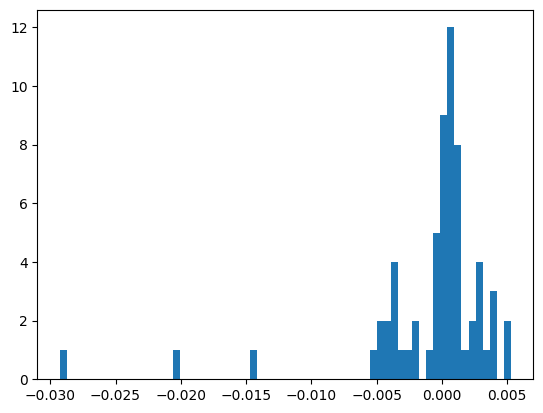

In [90]:
plt.hist(at_test1, bins=64)
plt.show()

In [91]:
order = np.argsort(at_test1)
print(channel_names[order])

['T7' 'F5' 'TP7' 'F6' 'F2' 'AF3' 'T8' 'F8' 'Fp1' 'C5' 'FT7' 'F3' 'AF7'
 'F7' 'FC5' 'FT8' 'FC6' 'C6' 'Fpz' 'CP5' 'FC3' 'AF8' 'F4' 'FC4' 'AF4'
 'TP8' 'Iz' 'Fp2' 'C3' 'FC1' 'AFz' 'P10' 'FC2' 'CP6' 'FCz' 'F1' 'CP2' 'C2'
 'CP4' 'Cz' 'C4' 'P8' 'Fz' 'P7' 'C1' 'CP3' 'P5' 'CP1' 'P6' 'P4' 'CPz'
 'PO8' 'P2' 'P3' 'P1' 'O2' 'Pz' 'Oz' 'PO7' 'PO4' 'P9' 'O1' 'POz' 'PO3']


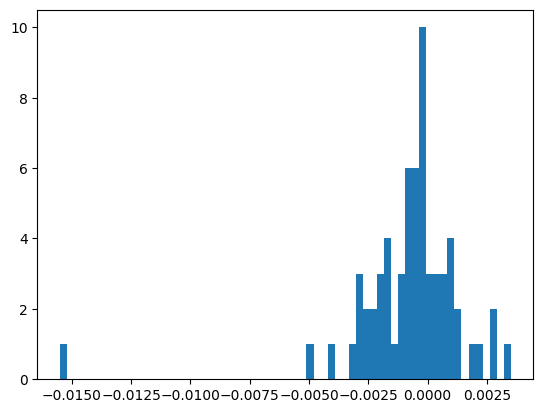

In [92]:
plt.hist(test1, bins=64)
plt.show()

In [93]:
order = np.argsort(test1)
print(channel_names[order])

['P9' 'TP7' 'F2' 'T7' 'F6' 'F5' 'F7' 'AF7' 'Fp1' 'FT8' 'F8' 'AF8' 'FC6'
 'CP5' 'AF3' 'C6' 'FC4' 'TP8' 'Fpz' 'P10' 'P7' 'FC2' 'FC3' 'C4' 'C3' 'FC5'
 'CP4' 'Fp2' 'CP3' 'C5' 'P8' 'C1' 'F3' 'C2' 'CP6' 'FC1' 'F4' 'PO4' 'Cz'
 'Pz' 'Iz' 'CP2' 'FT7' 'AF4' 'F1' 'P6' 'Fz' 'P5' 'PO8' 'FCz' 'AFz' 'CPz'
 'P1' 'T8' 'CP1' 'P4' 'P2' 'PO7' 'P3' 'O2' 'Oz' 'POz' 'O1' 'PO3']


In [94]:
print(kurtosis(test1))
print(skew(test1))

18.473542940281796
-3.3459438454384554


PCA heuristic idea

In [95]:
print(ones_epochs.get_data().shape)
print(channelstab_epochs.get_data().shape)

Using data from preloaded Raw for 479 events and 200 original time points ...
(479, 64, 200)
(480, 64, 100)


In [96]:
_, _, _, _, _, data_all, data_at_peaks = epoched_stability2(channelstab_epochs)

In [97]:
data = data_at_peaks.T

In [98]:
scaler = sklearn.preprocessing.StandardScaler()
data = scaler.fit_transform(data)

In [99]:
def pca_auc(data):
    pca = sklearn.decomposition.PCA(random_state=9)
    pca.fit_transform(data)
    roc_curve = np.ndarray(shape=pca.components_.shape[0])
    explained_var = pca.explained_variance_ratio_
    percent = 0
    for v in range(roc_curve.shape[0]):
        percent += explained_var[v]
        roc_curve[v] = percent
    auc = np.trapz(roc_curve.flatten())
    return auc/pca.components_.shape[0], roc_curve

0.9028379440321737


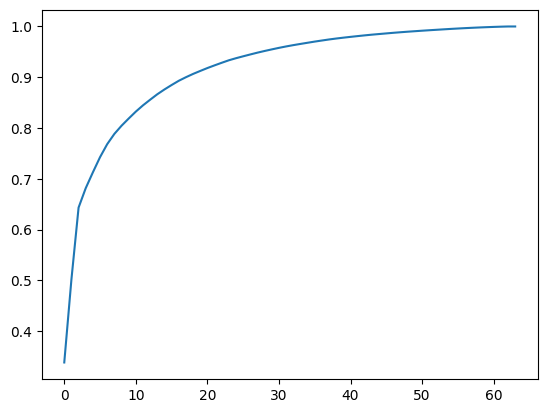

In [100]:
benchmark, rc = pca_auc(data)
print(benchmark)
plt.plot(rc)
plt.show()

In [101]:
pc_all_chanels = np.ndarray(64)
for c in range(len(channel_names)):
    dataaa = np.delete(data, c, axis=1)
    b, r = pca_auc(dataaa)
    pc_all_chanels[c] = b-benchmark

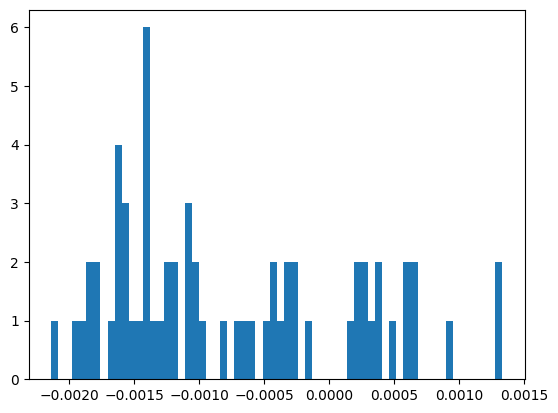

In [102]:
plt.hist(pc_all_chanels, bins=64)
plt.show()

In [103]:
order = np.argsort(pc_all_chanels)
print(channel_names[order])

['P1' 'Fz' 'POz' 'P2' 'F1' 'Oz' 'O1' 'CP1' 'FCz' 'FC1' 'P3' 'CPz' 'PO8'
 'PO3' 'P6' 'P4' 'PO7' 'Pz' 'O2' 'Cz' 'CP2' 'C1' 'P5' 'AF4' 'Fp2' 'C2'
 'FC3' 'CP4' 'CP6' 'C3' 'F4' 'CP3' 'Iz' 'AFz' 'AF8' 'C6' 'FC4' 'Fpz' 'P7'
 'C4' 'P10' 'FC5' 'C5' 'PO4' 'P8' 'FC6' 'FC2' 'Fp1' 'AF3' 'CP5' 'FT8' 'F3'
 'T7' 'FT7' 'F6' 'F8' 'AF7' 'TP7' 'TP8' 'F7' 'F5' 'F2' 'P9' 'T8']


In [104]:
bad_by_corr = np.where(pc_all_chanels > 0)[0]
print(channel_names[bad_by_corr])

['AF7' 'AF3' 'F3' 'F5' 'F7' 'FT7' 'T7' 'TP7' 'CP5' 'P9' 'F2' 'F6' 'F8'
 'FT8' 'T8' 'TP8']


In [105]:
idx = np.where((at_test1 < 0) & (test1 < 0) & (pc_all_chanels > 0))[0]
print(idx)

[ 1  2  4  5  6  7 14 15 16 38 40 41 42]


In [106]:
print(channel_names[idx])

['AF7' 'AF3' 'F3' 'F5' 'F7' 'FT7' 'T7' 'TP7' 'CP5' 'F2' 'F6' 'F8' 'FT8']


In [107]:
idx = np.where((at_test1 < 0) & (pc_all_chanels > 0))[0]
idx2 = np.where((test1 < 0) & (pc_all_chanels > 0))[0]
print(idx)
print(idx2)

[ 1  2  4  5  6  7 14 15 16 38 40 41 42 51]
[ 1  2  4  5  6  7 14 15 16 23 38 40 41 42 52]


In [108]:
print(channel_names[idx])
print(channel_names[idx2])

['AF7' 'AF3' 'F3' 'F5' 'F7' 'FT7' 'T7' 'TP7' 'CP5' 'F2' 'F6' 'F8' 'FT8'
 'T8']
['AF7' 'AF3' 'F3' 'F5' 'F7' 'FT7' 'T7' 'TP7' 'CP5' 'P9' 'F2' 'F6' 'F8'
 'FT8' 'TP8']


In [109]:
acum = []
for cn in channel_names[np.argsort(test1)]:
    if cn in channel_names[bad_by_corr]:
        print(cn)
        acum.append(cn)
    else:
        break
for cn in channel_names[np.argsort(at_test1)]:
    if cn in channel_names[bad_by_corr]:
        if cn not in acum:
            print(cn)
    else:
        break

P9
TP7
F2
T7
F6
F5
F7
AF7
AF3
T8
F8
